In [1]:
import timeit

import math
import fiona
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import geopandas as gp
import matplotlib.pyplot as plt

from random import random
from queue import PriorityQueue
from shapely.ops import nearest_points
from shapely.geometry import Polygon,Point, MultiPoint, box, LineString
from skgeom import Point2,Segment2,arrangement,intersection,RotationalSweepVisibility, draw

from ordered_set import OrderedSet

%matplotlib inline

np.random.seed(26) # 21 for 1200 0.88

In [2]:
from QDforMLV import QDkAlgo

from helpers import *

In [3]:
'''
    Division_of_T()
'''
def divideTarget(Target, numPortions):
    pLen = Target.length / numPortions
    tvx = list(Target.exterior.coords)
    portions = []

    for i in range(len(tvx)-1):
        sideLen = np.sqrt( (tvx[i][0]-tvx[i+1][0])**2 + (tvx[i][1]-tvx[i+1][1])**2 )
        # print(sideLen)
        pN = sideLen / pLen
        pN = max((int)(pN+0.5),1)
        xPL = (tvx[i][0]-tvx[i+1][0])/pN
        yPL = (tvx[i][1]-tvx[i+1][1])/pN
        # print(xPL,yPL)
        for pn in range(pN):
            portions.append(Segment2(Point2(tvx[i][0]-pn*xPL,tvx[i][1]-pn*yPL), Point2(tvx[i][0]-(pn+1)*xPL,tvx[i][1]-(pn+1)*yPL)))
            # portions.append(LineString([(tvx[i][0]-pn*xPL,tvx[i][1]-pn*yPL), (tvx[i][0]-(pn+1)*xPL,tvx[i][1]-(pn+1)*yPL)]))
            

    return portions


# Start

In [4]:
gdf = gp.read_file("datasets/obstacles400.gpkg")
qpGdf = gp.read_file("datasets/querypoints400.gpkg")

In [5]:

'''
    Visibility skgeom construction
'''
minx, miny, maxx, maxy = qpGdf.total_bounds*10000
minx-=10
miny-=10
maxx+=10
maxy+=10
outer = [
    Segment2(Point2(minx,miny), Point2(minx,maxy)), Segment2(Point2(minx,maxy), Point2(maxx,maxy)),
    Segment2(Point2(maxx,maxy), Point2(maxx,miny)), Segment2(Point2(maxx,miny), Point2(minx,miny))
]
arr = arrangement.Arrangement()

for bounds in outer:
    arr.insert(bounds)

Boundary = Polygon([(minx,miny),(minx,maxy),(maxx,maxy),(maxx,miny)])


In [6]:
'''
    Preprocessing our obstacle GeoDataFrame

        1. Simplifying building geometries
        2. Adding centroids
        x. Removing some obstacles randomly (not for prod?)
'''
gdf.drop(gdf[gdf['geometry'].type == 'Point'].index.values, inplace=True)
# envelope : convert to rectangles, simplify: reduce edges (also see shapely/geopandas docs)
simple = gdf['geometry'].convex_hull # REMOVING HOLES
simple = simple.simplify(0.5) # EDGE REDUCTION
gdf['geometry'] = simple
gdf['centroid'] = gdf.centroid

gdf = gdf.sample(frac=0.43)
print(gdf.shape)

(45, 60)


In [7]:
'''
    Building TARGET.
    We store a simple shapely polygon and the polygon formed from the portions for the vis ops.
'''
# Random Target
Target = gdf.sample(n=1)
# print(Target)
# Specific Target
# Target = gdf.loc[gdf['name'] == 'Museum of Contemporary Art'] # comment frac.

gdf.drop(Target.index, inplace=True)

In [8]:
'''
    Inserting Target in our arrangement
'''
targetVx = Target.geometry.exterior.iloc[0].coords
targetBuilder = []

for i in range(len(targetVx)-1):
    targetBuilder.append(Segment2(Point2(targetVx[i][0]*10000,targetVx[i][1]*10000), Point2(targetVx[i+1][0]*10000,targetVx[i+1][1]*10000)))

targetPolyBuilder = []
for i in range(len(targetVx)-1):
    targetPolyBuilder.append(Point(targetVx[i][0]*10000,targetVx[i][1]*10000))

scaledTarget = Polygon(targetPolyBuilder)


# for bounds in targetBuilder:
#     arr.insert(bounds)


In [9]:
number_of_portions = 16
portionsTarget = divideTarget(scaledTarget, number_of_portions)
# print(portionsTarget)

for bounds in portionsTarget:
    arr.insert(bounds)

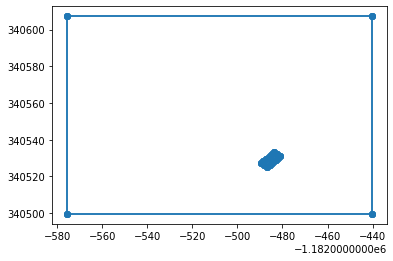

In [10]:
for he in arr.halfedges:
    draw.draw(he.curve())

In [22]:
treeNodes = []
for rtn in gdf.sindex.leaves():
    for rt in rtn[1]:
        treeNodes.append(rt)

print('No of obstacles:', len(treeNodes))

No of obstacles: 44


[19, 10, 21]
[12.788959, 12.663146, 7.04151]


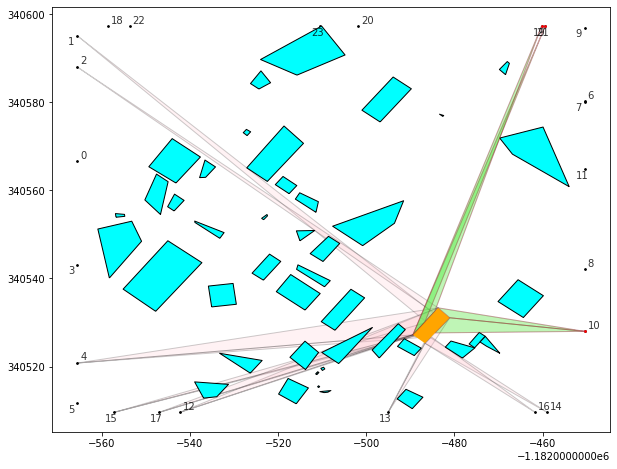

In [77]:
'''
    Run to get better looking unsplit VR Polygons
'''
# ax, ax_vis, ans_vrPoly, vxP, vxS = QDkAlgo(targetBuilder,outer, qpGdf, 3, gdf,Boundary, treeNodes)
# print(list(ax))
# print(list(ax_vis))
# # Print to get MV results
# plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vxP,ans_vrPoly,ax)

[19, 10, 21, 16, 13, 14, 1, 4, 2, 12, 17, 15, 5, 3, 0, 18, 22, 23, 20, 8, 7, 6, 9, 11]
[12.78771, 12.65984, 7.041348, 2.267958, 1.454382, 2.040126, 0.728627, 0.26353, 0.303371, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


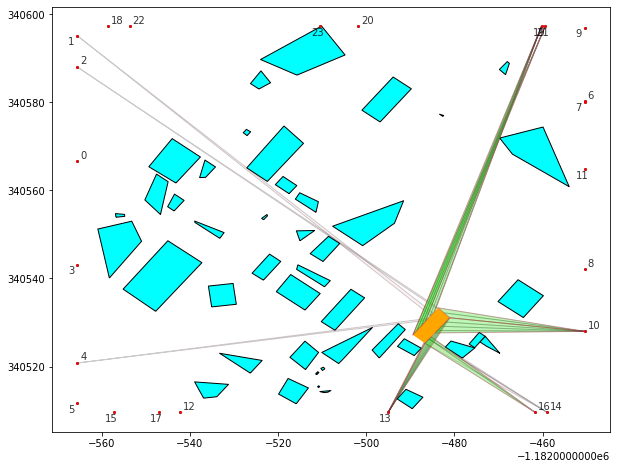

In [25]:
ans, ans_vis, ans_vrPolySplit, vrPolygons, vrSets = QDkAlgo(portionsTarget,outer, qpGdf, len(qpGdf.index), gdf,Boundary, treeNodes)
print(list(ans))
print(list(ans_vis))

# plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vrPolygons,ans_vrPolySplit,ans)
plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vrPolygons,ans_vrPolySplit,ans)

In [26]:
ansDict = dict(zip(ans, ans_vis))

In [27]:
'''
    Mapped pid : list of query points. portionTxn[i->portion]
'''
pList = [[] for _ in range(len(ans)+1)]
portionTxn = [[] for _ in range(number_of_portions+1)]

for i in range(len(portionsTarget)):
    por = portionsTarget[i]
    px = LineString([asPoint(por.source()), asPoint(por.target())])
    # Important to check reverse as well
    pxrev = LineString([asPoint(por.target()), asPoint(por.source())])
    for idx in ans:
        for seg in vrSets[idx]:
            sx = LineString([asPoint(seg.source()), asPoint(seg.target())])
            if (sx.almost_equals(px, 1) or sx.almost_equals(pxrev, 1)):
                pList[idx].append(i)

for i in range(len(pList)):
    for portionId in pList[i]:
        portionTxn[portionId].append(i)

In [28]:
# pList

In [29]:
# portionTxn

In [30]:
def str2vec(str):
    '''
        string -> list of ints
        *the string elements are already sorted
    '''
    retList = [int(i) for i in str.split() if i.isdigit()]
    return retList


In [31]:
def vec2str(arr, Qdict):
    '''
        list of ints -> string
    '''
    arr = sorted(arr, key = Qdict.get, reverse = True)
    retStr = ''
    strlist = [str(x) for x in arr]
    for num in strlist:
        retStr+=num
        retStr+=' '
    retStr = retStr.rstrip()
    return retStr

In [32]:
def unionStr(s1, s2, Qdict):
    '''
        @args
            s1 --> string 1
            s2 --> string 2
        @returns
            s1 U s2: as a LIST
    '''
    final = list(set(str2vec(s1)) | set(str2vec(s2)))
    final = sorted(final, key = Qdict.get, reverse = True)
    return final


In [33]:
def testPair(s1, s2):
    arr1 = str2vec(s1)
    arr2 = str2vec(s2)
    if (arr1[:-1] == arr2[:-1] and arr1[-1] != arr2[-1]):
        return True
    return False

In [34]:
def combine(arr1, arr2, l, Qdict):
    '''
        cross product of vectors of strings.
        @args
            arr1 --> vector of strings
            arr2 --> vector of strings
            l --> length of resultants to be considered
        @returns
            arr1 X arr2 but only tested elements
    '''
    finalArr = []
    for el1 in arr1:
        for el2 in arr2:
            if testPair(el1, el2):
                tempArr = unionStr(el1, el2, Qdict)
                if(len(tempArr) == l):
                    tempVec = vec2str(tempArr, Qdict)
                    if tempVec not in finalArr:
                        finalArr.append(tempVec)
    
    return finalArr


In [35]:
def overlap(c, QVR):
    qarr = str2vec(c)
    qk = qarr[-1]
    VRcj = set()
    for el in qarr[:-1]:
        VRcj |= set(QVR[el])

    VRqk = set(QVR[qk])

    oval = float(len(VRcj & VRqk))/(len(VRqk)+0.00001)
    return oval

In [36]:
def vis(c, QVR, numPortions):
    qarr = str2vec(c)
    VRs = set()
    for el in qarr:
        VRs |= set(QVR[el])
    
    return float(len(VRs)/numPortions)


In [37]:
def continuity(c, QVR):
    '''
        Leniency in case of 1 discontinuous portion
    '''
    qarr = str2vec(c)
    VRs = set()
    for el in qarr:
        VRs |= set(QVR[el])
    VRlist = list(VRs)
    VRlist.sort()
    # print(VRlist)

    if VRlist[-1]-VRlist[0]+1 == len(VRlist) or VRlist[-1]-VRlist[0]+1 == len(VRlist)+1:
        return True
    return False

In [38]:
# cc = "13 3 10"
# print(overlap(cc, pList))
# print(vis(cc, pList, number_of_portions))
# print(continuity(cc, pList))


In [74]:
'''
    Make sets using vec and strings
'''
def levelwiseMLV(S, minV, maxO, Qdict, QVR, nP):
    Q = [[] for _ in range(100)]
    C = [[],[]] # for the sake of consistency
    MLV = []
    ans_vis =[]
    i = 1
    for q in range(len(Qdict)):
        # pruning QPs with no complete visible portions
        if len(QVR[q]) > 1:
            Q[1].append(str(q))
    C.append(combine(Q[1],Q[1],i+1, Qdict))
    # print(C)
    while len(C[i+1]):
        for c in C[i+1]:
            # print(overlap(c,QVR))
            if overlap(c, QVR) <= maxO:
                if c not in Q[i+1]:
                    Q[i+1].append(c)
            if vis(c, QVR, nP) >= minV and continuity(c, QVR) == True:
                if c not in MLV:
                    ans_vis.append(vis(c, QVR, nP))
                    MLV.append(c)
        # print(Q)
        i += 1
        C.append(combine(Q[i],Q[i],i+1, Qdict))

    MLVRet = [x for y, x in sorted(zip(ans_vis, MLV),reverse=True)]
    ans_visRet = [y for y, x in sorted(zip(ans_vis, MLV),reverse=True)]

    return MLVRet, ans_visRet


ansMLV, ansVis = levelwiseMLV(portionTxn, 0.3, 0.9, ansDict, pList, number_of_portions)

In [75]:

print(ansMLV, ansVis)

['19 10 13', '19 10', '10 13', '19 21'] [0.8125, 0.625, 0.5, 0.3125]


[19, 10, 21, 16, 13, 14, 1, 4, 2, 12, 17, 15, 5, 3, 0, 18, 22, 23, 20, 8, 7, 6, 9, 11]
[12.788959, 12.663146, 7.04151, 2.268019, 1.441373, 2.040163, 0.728627, 0.26353, 0.303371, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


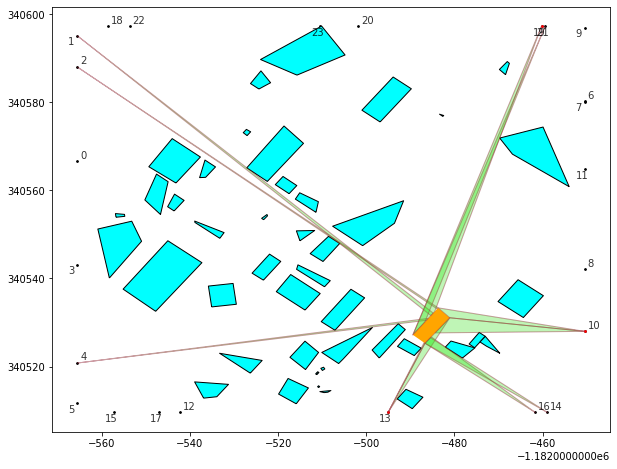

In [78]:
ax, ax_vis, ans_vrPoly, vxP, vxS = QDkAlgo(targetBuilder,outer, qpGdf, len(qpGdf.index), gdf,Boundary, treeNodes)
print(list(ax))
print(list(ax_vis))
# Print to get MV results
plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vxP,ans_vrPoly,str2vec(ansMLV[0]))